In [15]:
from neural_network import NeuralNetwork
from data import Instance, DataSet
from miscellaneous import initialize_data, plot_graph, plot_points
from activation_function import *
import matplotlib.pyplot as plt
import pandas as pd
import copy
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
import itertools
import time
warnings.filterwarnings('ignore')

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Carregando dados e Ajustando labels

In [17]:
start_time = time.time()

# Carregando dados
print('Carregando dados ...', end = '')
champ_stats = pd.read_csv('../dataset/champ_stats.csv')
champs = pd.read_csv('../dataset/champs.csv')
mtime = pd.read_csv('../dataset/matches_MODIFIED.csv')
participants = pd.read_csv('../dataset/participants.csv')
stats1 = pd.read_csv('../dataset/stats1_MODIFIED.csv')
stats2 = pd.read_csv('../dataset/stats2_MODIFIED.csv')
stats = pd.concat([stats1, stats2])
print( 28*'.'+' OK')

# Ajustando nomes
print('Ajustando nomes[1] ...', end = '')
champ_stats_labels = [i.lower() for i in champ_stats.columns.values]
rename_dict_champ_stats = { i: j for i,j in zip(champ_stats.columns.values, champ_stats_labels) }
champ_stats.rename(columns = rename_dict_champ_stats, inplace = True)
print( 26*'.'+' OK')

# Ajustando nomes
print('Ajustando nomes[2] ...', end = '')
champs_labels = [i.lower() for i in champs.columns.values]
rename_dict_champs = { i: j for i,j in zip(champs.columns.values, champs_labels) }
champs.rename(columns = rename_dict_champs, inplace = True)
print( 26*'.'+' OK')

# Removendo instâncias desnecessárias
print('Removendo instâncias desnecessárias ...', end = '')
champ_stats['name'] = champ_stats['name'].str.replace('\'', '')
champ_stats['name'] = champ_stats['name'].str.replace('\. ', '')
champ_stats = champ_stats[champ_stats['name'].isin(champs['name'])].reset_index(drop = True)
champs = champs.sort_values('name').reset_index(drop = True)
print( 9*'.'+' OK')

# Reduzindo dimensionalidade
print('Reduzindo dimensionalidade ...', end = '')
params = ['hp', 'hp5', 'mp', 'mp5', 'ad', 'ar', 'mr']
for param in params:
    champ_stats[param] = champ_stats[param] + 10*champ_stats[param+'+']
    champ_stats.drop(columns = [param+'+'], inplace = True)
    
champ_stats['as'] = champ_stats['as'] * ((1 + champ_stats['as+'])**10)
champ_stats.drop(columns = ['as+'], inplace = True)
print( 18*'.'+' OK')

# Removendo atributos desnecessários
print('Removendo atributos desnecessários ...', end = '')
#participants.drop(columns = ['player', 'ss1', 'ss2', 'id', 'matchid'], inplace = True)
participants.drop(columns = ['player', 'ss1', 'ss2'], inplace = True)
stats.drop(columns = ['trinket', 'assists', 'firstblood'], inplace = True)
print( 10*'.'+' OK')

# Juntando tabelas
print('Juntando tabelas ...', end = '')
participants.set_index('id', inplace = True)
stats.set_index('id', inplace = True)
dataset = pd.DataFrame.copy(participants)
dataset = dataset.join(pd.DataFrame.copy(stats))
print( 15*'.'+' OK')

# One-hot encoding para role e position
print('One-hot encoding para role e position ...', end = '')
dataset = pd.concat([dataset, pd.get_dummies( dataset['role'], prefix = 'role')],axis=1)
dataset = pd.concat([dataset, pd.get_dummies( dataset['position'], prefix = 'pos')],axis=1)
dataset.drop(['role', 'position'], axis = 1, inplace = True)
if 'role_DUO' not in dataset.columns.values:
    dataset['role_DUO'] = 0
print( 7*'.'+' OK        ')

# Substituindo IDs por nomes dos champions
print('Substituindo IDs por nomes dos champions ...', end = '')
s = champs.set_index('id')['name']
dataset['championid'] = dataset['championid'].replace(s)
print( 4*'.'+' OK       ')
        
# Juntando tabelas
print('Juntando tabelas ...', end = '')
params = ['hp', 'hp5', 'mp', 'mp5', 'ad', 'ar', 'as', 'mr', 'ms', 'range']
s = champ_stats.set_index('name')
for param in params:
    dataset[param] = dataset['championid']
    dataset[param] = dataset[param].replace(s[param])
dataset = dataset.reset_index(drop = True)
print( 28*'.'+' OK')

# Normalizando parametros
print('Normalizando duração ...', end = '')
min_max_s = MinMaxScaler(feature_range = (0.0, 1.0))
for col in ['hp', 'hp5', 'mp', 'mp5', 'ad', 'ar', 'mr', 'ms', 'range']:
    dataset[col] = min_max_s.fit_transform(dataset[col].values.reshape(-1, 1))
print( 20*'.'+' OK')

# Removendo o nome dos champios
print('Removendo o nome dos champios ...', end = '')
dataset.drop(columns = ['championid'], inplace = True)
print( 15*'.'+' OK      ')

# Reconstruindo linhas apropriadamente
print('Reconstruindo linhas apropriadamente ...', end = '')
tmp = pd.DataFrame()
columnNames = dataset.columns.values.tolist()
p = 0
for i in range(2):
    for j in range(5):
        ij = str(i)+str(j)
        p = dataset[i*5+j::10].rename( columns = { name: name+ij for name in columnNames} )
        if(tmp.empty):
            tmp = pd.DataFrame.copy(p).reset_index(drop = True)
        else:
            tmp = tmp.join(pd.DataFrame.copy(p).reset_index(drop = True))
dataset = tmp
print( 8*'.'+' OK')

# Removendo dados duplicados
print('Removendo dados duplicados ...', end = '')
dataset.dropna()
dataset['matchid'] = dataset['matchid00']
dataset['win0'] = dataset['win00']
dataset['win1'] = dataset['win10']
dataset['kills0'] = dataset['kills00'] + dataset['kills01'] + dataset['kills02'] + dataset['kills03'] + dataset['kills04']
dataset['kills1'] = dataset['kills10'] + dataset['kills11'] + dataset['kills12'] + dataset['kills13'] + dataset['kills14']
dataset['deaths0'] = dataset['deaths00'] + dataset['deaths01'] + dataset['deaths02'] + dataset['deaths03'] + dataset['deaths04']
dataset['deaths1'] = dataset['deaths10'] + dataset['deaths11'] + dataset['deaths12'] + dataset['deaths13'] + dataset['deaths14']
dataset['kd_ratio0'] = dataset['kills0']/dataset['deaths0']
dataset['kd_ratio1'] = dataset['kills1']/dataset['deaths1']

for i in range(2):
    for j in range(5):
        ij = str(i)+str(j)
        dataset.drop(columns = ['win'+ij, 'kills'+ij, 'deaths'+ij, 'matchid'+ij], inplace = True)
    dataset.drop(columns = ['deaths'+str(i), 'kills'+str(i)], inplace = True)

dataset = dataset.join(mtime)
dataset.drop(columns = ['id', 'matchid'], inplace = True)
print( 8*'.'+' OK')

# Normalizando duração
print('Normalizando duração ...', end = '')
min_max_s = MinMaxScaler(feature_range = (0.0, 1.0))
for col in ['duration']:
    dataset[col] = min_max_s.fit_transform(dataset[col].values.reshape(-1, 1))
print( 20*'.'+' OK')

# Calculando dificuldade
print('Calculando dificuldade ...', end = '')
kd0 = pd.Series.copy(dataset['kd_ratio0'])
kd0[ kd0 > 1.0 ] = 1.0
kd0[ kd0 < 1.0 ] = 0.0
kd1 = 1.0 - kd0
win0 = dataset['win0']
win1 = dataset['win1']

durationTerm = 1.0 - dataset['duration']
killTerm = 0.5 + 0.5 * (dataset['kd_ratio0'] * kd1 + dataset['kd_ratio1'] * kd0) * (win0 * kd0 + win1 * kd1) - 0.5 * (dataset['kd_ratio0'] * kd1 + dataset['kd_ratio1'] * kd0) * (win0 * kd1 + win1 * kd0)
       
dataset['dificult'] = durationTerm * 0.4 + killTerm * 0.6
dataset['dificult0'] = 0.5 + 0.5*( dataset['dificult'] * dataset['win1'] - dataset['dificult'] * dataset['win0']  )
dataset['dificult1'] = 0.5 + 0.5*( dataset['dificult'] * dataset['win0'] - dataset['dificult'] * dataset['win1']  )
dataset.drop(columns = ['win0', 'win1', 'dificult', 'duration'], inplace = True)
print( 20*'.'+' OK')
        
elapsed_time = time.time() - start_time
print('Tempo total ' + 33*'.' + ' ' + time.strftime("%M:%S", time.gmtime(elapsed_time)))
                                                       
#champ_stats.head()
#champs.head()
display(dataset)

Carregando dados ............................... OK
Ajustando nomes[1] ............................. OK
Ajustando nomes[2] ............................. OK
Removendo instâncias desnecessárias ............ OK
Reduzindo dimensionalidade ..................... OK
Removendo atributos desnecessários ............. OK
Juntando tabelas .................. OK
One-hot encoding para role e position .......... OK        
Substituindo IDs por nomes dos champions ....... OK       
Juntando tabelas ............................... OK
Normalizando duração ....................... OK
Removendo o nome dos champios .................. OK      
Reconstruindo linhas apropriadamente ........... OK
Removendo dados duplicados ........... OK
Normalizando duração ....................... OK
Calculando dificuldade ....................... OK
Tempo total ................................. 04:15


,role_DUO00,role_DUO_CARRY00,role_DUO_SUPPORT00,role_NONE00,role_SOLO00,pos_BOT00,pos_JUNGLE00,pos_MID00,pos_TOP00,hp00,...,ad14,ar14,as14,mr14,ms14,range14,kd_ratio0,kd_ratio1,dificult0,dificult1
0,0,0,0,1,0,0,1,0,0,0.560748,...,0.444805,0.489492,0.715395,0.023669,0.625,0.761905,0.512821,1.950000,0.855313,0.144687
1,0,0,1,0,0,1,0,0,0,0.647975,...,0.561404,0.627119,0.800898,0.591716,0.500,0.000000,1.031250,0.969697,0.641933,0.358067
2,0,1,0,0,0,1,0,0,0,0.526106,...,0.457895,0.576271,0.946749,0.023669,0.375,0.809524,0.625000,1.600000,0.889928,0.110072
3,0,0,0,0,1,0,0,1,0,0.635514,...,0.333333,0.495186,0.715395,0.023669,0.250,0.809524,0.923077,1.083333,0.914977,0.085023
4,0,0,0,0,1,0,0,1,0,0.623053,...,0.516842,0.599729,0.727485,0.023669,0.500,0.619048,1.085714,0.846154,0.644885,0.355115
5,0,1,0,0,0,1,0,0,0,0.529595,...,0.543860,0.610169,0.857657,0.467456,0.750,0.095238,1.833333,0.545455,0.126628,0.873372
6,0,0,0,1,0,0,1,0,0,0.745421,...,0.561404,0.627119,0.800898,0.591716,0.500,0.000000,0.622222,1.607143,0.885054,0.114946
7,0,0,0,1,0,0,1,0,0,0.745421,...,0.561404,0.627119,0.800898,0.591716,0.500,0.000000,0.580645,1.722222,0.875693,0.124307
8,0,0,0,0,1,0,0,1,0,0.467290,...,0.400000,0.661017,0.840779,0.023669,0.250,1.000000,0.820513,1.218750,0.902883,0.097117
9,0,0,0,0,1,0,0,0,1,0.771963,...,0.561404,0.627119,0.800898,0.591716,0.500,0.000000,1.600000,0.625000,0.112530,0.887470


##### Encontrando correlações

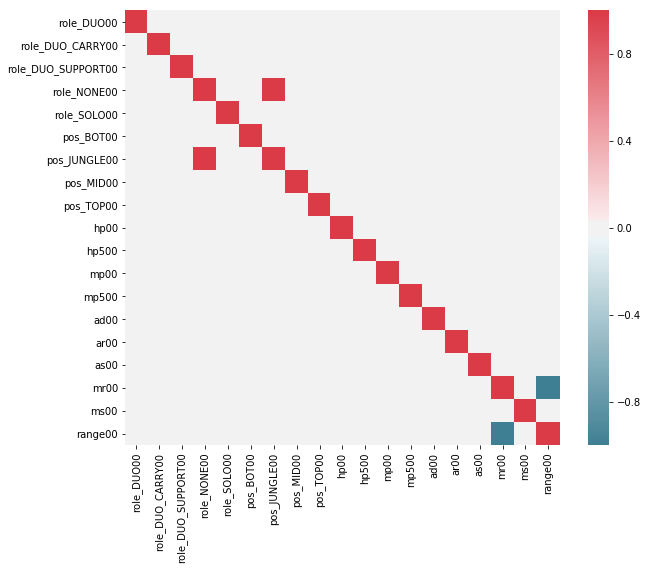

In [18]:
atr = dataset.columns.values.tolist()
corr = dataset[atr[0:19]].corr() * (0.5 / 0.7)
corr = corr.round(0)

f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = True, ax = ax)

In [19]:
for i in range(2):
    for j in range(5):
        ij = str(i)+str(j)
        dataset.drop(columns = ['hp5'+ij, 'mr'+ij, 'role_NONE'+ij], inplace = True)

display(dataset)

,role_DUO00,role_DUO_CARRY00,role_DUO_SUPPORT00,role_SOLO00,pos_BOT00,pos_JUNGLE00,pos_MID00,pos_TOP00,hp00,mp00,...,mp514,ad14,ar14,as14,ms14,range14,kd_ratio0,kd_ratio1,dificult0,dificult1
0,0,0,0,0,0,1,0,0,0.560748,0.590109,...,0.32000,0.444805,0.489492,0.715395,0.625,0.761905,0.512821,1.950000,0.855313,0.144687
1,0,0,1,0,1,0,0,0,0.647975,0.669726,...,0.26432,0.561404,0.627119,0.800898,0.500,0.000000,1.031250,0.969697,0.641933,0.358067
2,0,1,0,0,1,0,0,0,0.526106,0.703035,...,0.23512,0.457895,0.576271,0.946749,0.375,0.809524,0.625000,1.600000,0.889928,0.110072
3,0,0,0,1,0,0,1,0,0.635514,0.781191,...,0.24000,0.333333,0.495186,0.715395,0.250,0.809524,0.923077,1.083333,0.914977,0.085023
4,0,0,0,1,0,0,1,0,0.623053,0.625703,...,0.38000,0.516842,0.599729,0.727485,0.500,0.619048,1.085714,0.846154,0.644885,0.355115
5,0,1,0,0,1,0,0,0,0.529595,0.633046,...,0.00000,0.543860,0.610169,0.857657,0.750,0.095238,1.833333,0.545455,0.126628,0.873372
6,0,0,0,0,0,1,0,0,0.745421,0.628100,...,0.26432,0.561404,0.627119,0.800898,0.500,0.000000,0.622222,1.607143,0.885054,0.114946
7,0,0,0,0,0,1,0,0,0.745421,0.628100,...,0.26432,0.561404,0.627119,0.800898,0.500,0.000000,0.580645,1.722222,0.875693,0.124307
8,0,0,0,1,0,0,1,0,0.467290,0.669726,...,0.25800,0.400000,0.661017,0.840779,0.250,1.000000,0.820513,1.218750,0.902883,0.097117
9,0,0,0,1,0,0,0,1,0.771963,0.655676,...,0.26432,0.561404,0.627119,0.800898,0.500,0.000000,1.600000,0.625000,0.112530,0.887470


##### Construindo conjuntos de treino e teste

In [40]:
new_io = pd.DataFrame.copy(dataset)
new_io = new_io.dropna()
params = new_io.columns.values.tolist()

team0win = new_io[new_io['dificult0'] < 0.25].filter(params[0:80])
team1win = new_io[new_io['dificult1'] < 0.25].filter(params[80:160])

# x = new_io.filter(params[0:160], axis = 1)
# y = new_io.filter(['dificult0', 'dificult1'], axis = 1)

x = team0win.filter(params[0:64], axis = 1)
y = team0win.filter(params[64:80], axis = 1)

finalDataset = DataSet() 
for inst_x, inst_y in zip(x.iterrows(), y.iterrows()):
    index_x, data_x = inst_x
    index_y, data_y = inst_y
    finalDataset.add(Instance(data_x.tolist(), data_y.tolist()))
    
x = team1win.filter(params[80:144], axis = 1)
y = team1win.filter(params[144:160], axis = 1)

for inst_x, inst_y in zip(x.iterrows(), y.iterrows()):
    index_x, data_x = inst_x
    index_y, data_y = inst_y
    finalDataset.add(Instance(data_x.tolist(), data_y.tolist()))

if(new_io.isnull().values.any()):
    print(new_io.isnull().sum().sum())
else:
    print('Tudo OK')

Tudo OK


In [67]:
net = NeuralNetwork(64, [16], 5*[sig_func], dropout = [0.1, 0.0, 0.2, 0.0])
data = net.fit(finalDataset, "mini-batch", 250, lr_ = 0.6, momentum_ = 0.99, type = "reg", mini_batch_size = 50, 
                      tvt_ratio = [70, 30, 0], print_info = True, opt = 'adadelta', loss_ = 'logcosh')

Train on 96177 samples, validate on 41219 samples
Epoch 1/250
96177/96177 [==============================] - 7s 68us/step - loss: 0.0472 - val_loss: 0.0388
Epoch 2/250
96177/96177 [==============================] - 5s 53us/step - loss: 0.0367 - val_loss: 0.0326
Epoch 3/250
96177/96177 [==============================] - 5s 52us/step - loss: 0.0315 - val_loss: 0.0293
Epoch 4/250
96177/96177 [==============================] - 5s 54us/step - loss: 0.0287 - val_loss: 0.0273
Epoch 5/250
96177/96177 [==============================] - 5s 53us/step - loss: 0.0270 - val_loss: 0.0260
Epoch 6/250
96177/96177 [==============================] - 5s 52us/step - loss: 0.0259 - val_loss: 0.0252
Epoch 7/250
96177/96177 [==============================] - 5s 53us/step - loss: 0.0252 - val_loss: 0.0246
Epoch 8/250
96177/96177 [==============================] - 5s 53us/step - loss: 0.0246 - val_loss: 0.0242
Epoch 9/250
96177/96177 [==============================] - 5s 53us/step - loss: 0.0242 - val_loss: 0.0

96177/96177 [==============================] - 5s 50us/step - loss: 0.0213 - val_loss: 0.0212
Epoch 154/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0212 - val_loss: 0.0212
Epoch 155/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0212 - val_loss: 0.0212
Epoch 156/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0212 - val_loss: 0.0212
Epoch 157/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0212 - val_loss: 0.0212
Epoch 158/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0212 - val_loss: 0.0212
Epoch 159/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0212 - val_loss: 0.0212
Epoch 160/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0212 - val_loss: 0.0212
Epoch 161/250
96177/96177 [==============================] - 5s 51us/step - loss: 0.0212 - val_loss: 0.0212
Epoch 162/250
96177/96177 [===============

Epoch 229/250
96177/96177 [==============================] - 5s 52us/step - loss: 0.0211 - val_loss: 0.0211
Epoch 230/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0211 - val_loss: 0.0211
Epoch 231/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0211 - val_loss: 0.0211
Epoch 232/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0211 - val_loss: 0.0211
Epoch 233/250
96177/96177 [==============================] - 5s 51us/step - loss: 0.0212 - val_loss: 0.0211
Epoch 234/250
96177/96177 [==============================] - 5s 52us/step - loss: 0.0211 - val_loss: 0.0211
Epoch 235/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0211 - val_loss: 0.0211
Epoch 236/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0211 - val_loss: 0.0211
Epoch 237/250
96177/96177 [==============================] - 5s 50us/step - loss: 0.0211 - val_loss: 0.0211
Epoch 238/250
96177/96177 [=

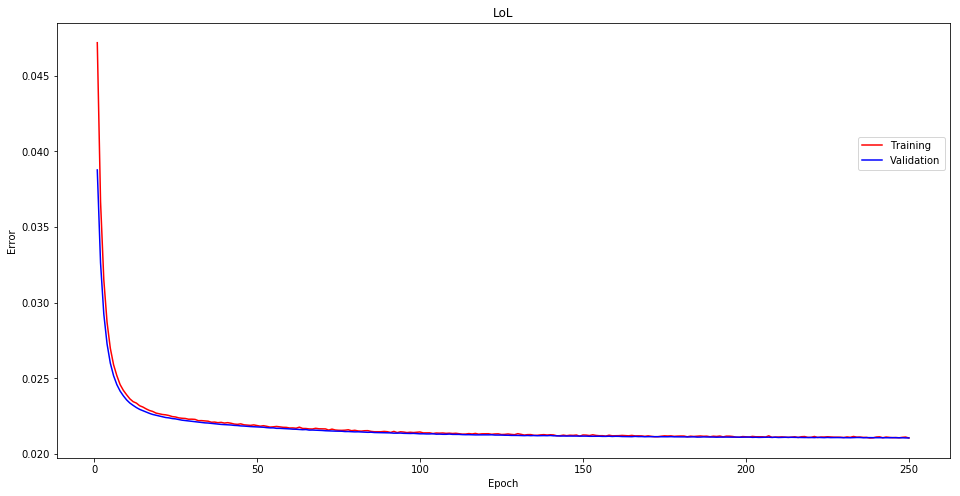

In [68]:
plot_graph(data, "LoL", "Epoch", "Error", figsizex = 16, figsizey = 8)

In [69]:
att = ['hp', 'mp', 'mp5', 'ad', 'ar', 'as', 'ms', 'range']
norm = champ_stats.filter(['name']+att, axis = 1)
min_max_s = MinMaxScaler(feature_range = (0.0, 1.0))
for col in att:
    norm[col] = min_max_s.fit_transform(norm[col].values.reshape(-1, 1))
print( 20*'.'+' OK')

norm = pd.concat([norm, pd.get_dummies( norm['name'], prefix = '')],axis=1)
norm.drop(columns = ['name'], inplace = True)

.................... OK


In [ ]:
cv = norm.columns.values.tolist()
x0 = norm.filter(cv[0:8], axis = 1)
y0 = norm.filter(cv[8:146], axis = 1) #146

newDataset = DataSet() 
for inst_x, inst_y in zip(x0.iterrows(), y0.iterrows()):
    index_x, data_x = inst_x
    index_y, data_y = inst_y
    newDataset.add(Instance(data_x.tolist(), data_y.tolist()))

In [80]:
net0 = NeuralNetwork(8, [16, 32, 64, 128, 138], [relu_func, relu_func, relu_func, relu_func, soft_max_func])
data0 = net0.fit(newDataset, "mini-batch", 17000, lr_ = 0.01, momentum_ = 0.3, type = "class", mini_batch_size = 8, 
                      tvt_ratio = [1, 0, 0], print_info = True, opt = 'adadelta', loss_ = 'categorical_crossentropy')

Epoch 1/17000
138/138 [==============================] - 3s 23ms/step - loss: 4.9252 - categorical_accuracy: 0.0072
Epoch 2/17000
138/138 [==============================] - 0s 707us/step - loss: 4.9252 - categorical_accuracy: 0.0072
Epoch 3/17000
138/138 [==============================] - 0s 693us/step - loss: 4.9251 - categorical_accuracy: 0.0072
Epoch 4/17000
138/138 [==============================] - 0s 660us/step - loss: 4.9251 - categorical_accuracy: 0.0072
Epoch 5/17000
138/138 [==============================] - 0s 794us/step - loss: 4.9251 - categorical_accuracy: 0.0072
Epoch 6/17000
138/138 [==============================] - 0s 830us/step - loss: 4.9251 - categorical_accuracy: 0.0072
Epoch 7/17000
138/138 [==============================] - 0s 714us/step - loss: 4.9250 - categorical_accuracy: 0.0072
Epoch 8/17000
138/138 [==============================] - 0s 693us/step - loss: 4.9250 - categorical_accuracy: 0.0072
Epoch 9/17000
138/138 [==============================] - 0s 751us

138/138 [==============================] - 0s 598us/step - loss: 4.9236 - categorical_accuracy: 0.0072
Epoch 71/17000
138/138 [==============================] - 0s 631us/step - loss: 4.9236 - categorical_accuracy: 0.0072
Epoch 72/17000
138/138 [==============================] - 0s 609us/step - loss: 4.9236 - categorical_accuracy: 0.0072
Epoch 73/17000
138/138 [==============================] - 0s 609us/step - loss: 4.9236 - categorical_accuracy: 0.0072
Epoch 74/17000
138/138 [==============================] - 0s 566us/step - loss: 4.9235 - categorical_accuracy: 0.0072
Epoch 75/17000
138/138 [==============================] - 0s 656us/step - loss: 4.9235 - categorical_accuracy: 0.0072
Epoch 76/17000
138/138 [==============================] - 0s 605us/step - loss: 4.9235 - categorical_accuracy: 0.0072
Epoch 77/17000
138/138 [==============================] - 0s 573us/step - loss: 4.9235 - categorical_accuracy: 0.0072
Epoch 78/17000
138/138 [==============================] - 0s 569us/step

138/138 [==============================] - 0s 577us/step - loss: 4.9206 - categorical_accuracy: 0.0145
Epoch 207/17000
138/138 [==============================] - 0s 595us/step - loss: 4.9206 - categorical_accuracy: 0.0145
Epoch 208/17000
138/138 [==============================] - 0s 656us/step - loss: 4.9206 - categorical_accuracy: 0.0145
Epoch 209/17000
138/138 [==============================] - 0s 602us/step - loss: 4.9206 - categorical_accuracy: 0.0145
Epoch 210/17000
138/138 [==============================] - 0s 616us/step - loss: 4.9205 - categorical_accuracy: 0.0145
Epoch 211/17000
138/138 [==============================] - 0s 580us/step - loss: 4.9205 - categorical_accuracy: 0.0145
Epoch 212/17000
138/138 [==============================] - 0s 627us/step - loss: 4.9205 - categorical_accuracy: 0.0145
Epoch 213/17000
138/138 [==============================] - 0s 587us/step - loss: 4.9205 - categorical_accuracy: 0.0145
Epoch 214/17000
138/138 [==============================] - 0s 58

138/138 [==============================] - 0s 609us/step - loss: 4.9171 - categorical_accuracy: 0.0145
Epoch 344/17000
138/138 [==============================] - 0s 635us/step - loss: 4.9171 - categorical_accuracy: 0.0145
Epoch 345/17000
138/138 [==============================] - 0s 627us/step - loss: 4.9170 - categorical_accuracy: 0.0145
Epoch 346/17000
138/138 [==============================] - 0s 638us/step - loss: 4.9170 - categorical_accuracy: 0.0145
Epoch 347/17000
138/138 [==============================] - 0s 566us/step - loss: 4.9170 - categorical_accuracy: 0.0145
Epoch 348/17000
138/138 [==============================] - 0s 725us/step - loss: 4.9169 - categorical_accuracy: 0.0145
Epoch 349/17000
138/138 [==============================] - 0s 656us/step - loss: 4.9169 - categorical_accuracy: 0.0145
Epoch 350/17000
138/138 [==============================] - 0s 867us/step - loss: 4.9169 - categorical_accuracy: 0.0145
Epoch 351/17000
138/138 [==============================] - 0s 51

Epoch 412/17000
138/138 [==============================] - 0s 522us/step - loss: 4.9147 - categorical_accuracy: 0.0145
Epoch 413/17000
138/138 [==============================] - 0s 518us/step - loss: 4.9147 - categorical_accuracy: 0.0145
Epoch 414/17000
138/138 [==============================] - 0s 529us/step - loss: 4.9147 - categorical_accuracy: 0.0145
Epoch 415/17000
138/138 [==============================] - 0s 587us/step - loss: 4.9146 - categorical_accuracy: 0.0145
Epoch 416/17000
138/138 [==============================] - 0s 547us/step - loss: 4.9146 - categorical_accuracy: 0.0145
Epoch 417/17000
138/138 [==============================] - 0s 562us/step - loss: 4.9146 - categorical_accuracy: 0.0145
Epoch 418/17000
138/138 [==============================] - 0s 551us/step - loss: 4.9145 - categorical_accuracy: 0.0145
Epoch 419/17000
138/138 [==============================] - 0s 551us/step - loss: 4.9145 - categorical_accuracy: 0.0145
Epoch 420/17000
138/138 [=======================

138/138 [==============================] - 0s 518us/step - loss: 4.9086 - categorical_accuracy: 0.0217
Epoch 548/17000
138/138 [==============================] - 0s 522us/step - loss: 4.9085 - categorical_accuracy: 0.0217
Epoch 549/17000
138/138 [==============================] - 0s 526us/step - loss: 4.9085 - categorical_accuracy: 0.0217
Epoch 550/17000
138/138 [==============================] - 0s 566us/step - loss: 4.9084 - categorical_accuracy: 0.0217
Epoch 551/17000
138/138 [==============================] - 0s 547us/step - loss: 4.9084 - categorical_accuracy: 0.0217
Epoch 552/17000
138/138 [==============================] - 0s 547us/step - loss: 4.9083 - categorical_accuracy: 0.0217
Epoch 553/17000
138/138 [==============================] - 0s 555us/step - loss: 4.9083 - categorical_accuracy: 0.0217
Epoch 554/17000
138/138 [==============================] - 0s 547us/step - loss: 4.9082 - categorical_accuracy: 0.0217
Epoch 555/17000
138/138 [==============================] - 0s 56

Epoch 616/17000
138/138 [==============================] - 0s 547us/step - loss: 4.9042 - categorical_accuracy: 0.0217
Epoch 617/17000
138/138 [==============================] - 0s 508us/step - loss: 4.9041 - categorical_accuracy: 0.0217
Epoch 618/17000
138/138 [==============================] - 0s 544us/step - loss: 4.9040 - categorical_accuracy: 0.0217
Epoch 619/17000
138/138 [==============================] - 0s 493us/step - loss: 4.9039 - categorical_accuracy: 0.0217
Epoch 620/17000
138/138 [==============================] - 0s 497us/step - loss: 4.9039 - categorical_accuracy: 0.0217
Epoch 621/17000
138/138 [==============================] - 0s 526us/step - loss: 4.9038 - categorical_accuracy: 0.0217
Epoch 622/17000
138/138 [==============================] - 0s 482us/step - loss: 4.9037 - categorical_accuracy: 0.0217
Epoch 623/17000
138/138 [==============================] - 0s 522us/step - loss: 4.9036 - categorical_accuracy: 0.0217
Epoch 624/17000
138/138 [=======================

Epoch 753/17000
138/138 [==============================] - 0s 616us/step - loss: 4.8909 - categorical_accuracy: 0.0217
Epoch 754/17000
138/138 [==============================] - 0s 558us/step - loss: 4.8908 - categorical_accuracy: 0.0217
Epoch 755/17000
138/138 [==============================] - 0s 540us/step - loss: 4.8907 - categorical_accuracy: 0.0217
Epoch 756/17000
138/138 [==============================] - 0s 602us/step - loss: 4.8906 - categorical_accuracy: 0.0217
Epoch 757/17000
138/138 [==============================] - 0s 537us/step - loss: 4.8905 - categorical_accuracy: 0.0217
Epoch 758/17000
138/138 [==============================] - 0s 576us/step - loss: 4.8903 - categorical_accuracy: 0.0217
Epoch 759/17000
138/138 [==============================] - 0s 573us/step - loss: 4.8902 - categorical_accuracy: 0.0217
Epoch 760/17000
138/138 [==============================] - 0s 555us/step - loss: 4.8901 - categorical_accuracy: 0.0217
Epoch 761/17000
138/138 [=======================

Epoch 890/17000
138/138 [==============================] - 0s 587us/step - loss: 4.8693 - categorical_accuracy: 0.0290
Epoch 891/17000
138/138 [==============================] - 0s 620us/step - loss: 4.8691 - categorical_accuracy: 0.0217
Epoch 892/17000
138/138 [==============================] - 0s 587us/step - loss: 4.8688 - categorical_accuracy: 0.0217
Epoch 893/17000
138/138 [==============================] - 0s 562us/step - loss: 4.8686 - categorical_accuracy: 0.0290
Epoch 894/17000
138/138 [==============================] - 0s 566us/step - loss: 4.8684 - categorical_accuracy: 0.0217
Epoch 895/17000
138/138 [==============================] - 0s 587us/step - loss: 4.8682 - categorical_accuracy: 0.0290
Epoch 896/17000
138/138 [==============================] - 0s 580us/step - loss: 4.8680 - categorical_accuracy: 0.0217
Epoch 897/17000
138/138 [==============================] - 0s 598us/step - loss: 4.8678 - categorical_accuracy: 0.0217
Epoch 898/17000
138/138 [=======================

138/138 [==============================] - 0s 870us/step - loss: 4.8330 - categorical_accuracy: 0.0290
Epoch 1027/17000
138/138 [==============================] - 0s 642us/step - loss: 4.8327 - categorical_accuracy: 0.0290
Epoch 1028/17000
138/138 [==============================] - 0s 732us/step - loss: 4.8323 - categorical_accuracy: 0.0290
Epoch 1029/17000
138/138 [==============================] - 0s 598us/step - loss: 4.8320 - categorical_accuracy: 0.0290
Epoch 1030/17000
138/138 [==============================] - 0s 979us/step - loss: 4.8316 - categorical_accuracy: 0.0290
Epoch 1031/17000
138/138 [==============================] - 0s 1ms/step - loss: 4.8313 - categorical_accuracy: 0.0290
Epoch 1032/17000
138/138 [==============================] - 0s 758us/step - loss: 4.8309 - categorical_accuracy: 0.0290
Epoch 1033/17000
138/138 [==============================] - 0s 674us/step - loss: 4.8305 - categorical_accuracy: 0.0290
Epoch 1034/17000
138/138 [==============================] -

138/138 [==============================] - 0s 576us/step - loss: 4.7726 - categorical_accuracy: 0.0290
Epoch 1161/17000
138/138 [==============================] - 0s 533us/step - loss: 4.7720 - categorical_accuracy: 0.0362
Epoch 1162/17000
138/138 [==============================] - 0s 529us/step - loss: 4.7714 - categorical_accuracy: 0.0362
Epoch 1163/17000
138/138 [==============================] - 0s 573us/step - loss: 4.7709 - categorical_accuracy: 0.0362
Epoch 1164/17000
138/138 [==============================] - 0s 540us/step - loss: 4.7703 - categorical_accuracy: 0.0362
Epoch 1165/17000
138/138 [==============================] - 0s 537us/step - loss: 4.7697 - categorical_accuracy: 0.0290
Epoch 1166/17000
138/138 [==============================] - 0s 526us/step - loss: 4.7691 - categorical_accuracy: 0.0362
Epoch 1167/17000
138/138 [==============================] - 0s 511us/step - loss: 4.7686 - categorical_accuracy: 0.0362
Epoch 1168/17000
138/138 [==============================]

138/138 [==============================] - 0s 540us/step - loss: 4.6797 - categorical_accuracy: 0.0362
Epoch 1296/17000
138/138 [==============================] - 0s 573us/step - loss: 4.6790 - categorical_accuracy: 0.0362
Epoch 1297/17000
138/138 [==============================] - 0s 544us/step - loss: 4.6782 - categorical_accuracy: 0.0362
Epoch 1298/17000
138/138 [==============================] - 0s 566us/step - loss: 4.6773 - categorical_accuracy: 0.0362
Epoch 1299/17000
138/138 [==============================] - 0s 533us/step - loss: 4.6765 - categorical_accuracy: 0.0362
Epoch 1300/17000
138/138 [==============================] - 0s 547us/step - loss: 4.6757 - categorical_accuracy: 0.0362
Epoch 1301/17000
138/138 [==============================] - 0s 555us/step - loss: 4.6749 - categorical_accuracy: 0.0362
Epoch 1302/17000
138/138 [==============================] - 0s 537us/step - loss: 4.6741 - categorical_accuracy: 0.0362
Epoch 1303/17000
138/138 [==============================]

138/138 [==============================] - 0s 562us/step - loss: 4.5637 - categorical_accuracy: 0.0362
Epoch 1431/17000
138/138 [==============================] - 0s 533us/step - loss: 4.5628 - categorical_accuracy: 0.0362
Epoch 1432/17000
138/138 [==============================] - 0s 540us/step - loss: 4.5619 - categorical_accuracy: 0.0362
Epoch 1433/17000
138/138 [==============================] - 0s 504us/step - loss: 4.5610 - categorical_accuracy: 0.0362
Epoch 1434/17000
138/138 [==============================] - 0s 537us/step - loss: 4.5601 - categorical_accuracy: 0.0362
Epoch 1435/17000
138/138 [==============================] - 0s 526us/step - loss: 4.5592 - categorical_accuracy: 0.0362
Epoch 1436/17000
138/138 [==============================] - 0s 526us/step - loss: 4.5583 - categorical_accuracy: 0.0362
Epoch 1437/17000
138/138 [==============================] - 0s 595us/step - loss: 4.5574 - categorical_accuracy: 0.0362
Epoch 1438/17000
138/138 [==============================]

138/138 [==============================] - 0s 714us/step - loss: 4.4490 - categorical_accuracy: 0.0362
Epoch 1565/17000
138/138 [==============================] - 0s 642us/step - loss: 4.4482 - categorical_accuracy: 0.0362
Epoch 1566/17000
138/138 [==============================] - 0s 577us/step - loss: 4.4474 - categorical_accuracy: 0.0362
Epoch 1567/17000
138/138 [==============================] - 0s 595us/step - loss: 4.4467 - categorical_accuracy: 0.0362
Epoch 1568/17000
138/138 [==============================] - 0s 576us/step - loss: 4.4459 - categorical_accuracy: 0.0362
Epoch 1569/17000
138/138 [==============================] - 0s 598us/step - loss: 4.4451 - categorical_accuracy: 0.0362
Epoch 1570/17000
138/138 [==============================] - 0s 591us/step - loss: 4.4443 - categorical_accuracy: 0.0362
Epoch 1571/17000
138/138 [==============================] - 0s 598us/step - loss: 4.4435 - categorical_accuracy: 0.0362
Epoch 1572/17000
138/138 [==============================]

138/138 [==============================] - 0s 649us/step - loss: 4.3566 - categorical_accuracy: 0.0362
Epoch 1700/17000
138/138 [==============================] - 0s 613us/step - loss: 4.3561 - categorical_accuracy: 0.0362
Epoch 1701/17000
138/138 [==============================] - 0s 580us/step - loss: 4.3555 - categorical_accuracy: 0.0362
Epoch 1702/17000
138/138 [==============================] - 0s 591us/step - loss: 4.3549 - categorical_accuracy: 0.0362
Epoch 1703/17000
138/138 [==============================] - 0s 577us/step - loss: 4.3543 - categorical_accuracy: 0.0362
Epoch 1704/17000
138/138 [==============================] - 0s 634us/step - loss: 4.3537 - categorical_accuracy: 0.0362
Epoch 1705/17000
138/138 [==============================] - 0s 558us/step - loss: 4.3532 - categorical_accuracy: 0.0362
Epoch 1706/17000
138/138 [==============================] - 0s 638us/step - loss: 4.3526 - categorical_accuracy: 0.0362
Epoch 1707/17000
138/138 [==============================]

138/138 [==============================] - 0s 566us/step - loss: 4.2861 - categorical_accuracy: 0.0362
Epoch 1835/17000
138/138 [==============================] - 0s 566us/step - loss: 4.2857 - categorical_accuracy: 0.0362
Epoch 1836/17000
138/138 [==============================] - 0s 566us/step - loss: 4.2852 - categorical_accuracy: 0.0362
Epoch 1837/17000
138/138 [==============================] - 0s 566us/step - loss: 4.2847 - categorical_accuracy: 0.0362
Epoch 1838/17000
138/138 [==============================] - 0s 566us/step - loss: 4.2842 - categorical_accuracy: 0.0362
Epoch 1839/17000
138/138 [==============================] - 0s 566us/step - loss: 4.2838 - categorical_accuracy: 0.0362
Epoch 1840/17000
138/138 [==============================] - 0s 566us/step - loss: 4.2833 - categorical_accuracy: 0.0362
Epoch 1841/17000
138/138 [==============================] - 0s 566us/step - loss: 4.2829 - categorical_accuracy: 0.0362
Epoch 1842/17000
138/138 [==============================]

Epoch 1902/17000
138/138 [==============================] - 0s 616us/step - loss: 4.2555 - categorical_accuracy: 0.0362
Epoch 1903/17000
138/138 [==============================] - 0s 732us/step - loss: 4.2550 - categorical_accuracy: 0.0362
Epoch 1904/17000
138/138 [==============================] - 0s 682us/step - loss: 4.2546 - categorical_accuracy: 0.0362
Epoch 1905/17000
138/138 [==============================] - 0s 682us/step - loss: 4.2542 - categorical_accuracy: 0.0362
Epoch 1906/17000
138/138 [==============================] - 0s 747us/step - loss: 4.2538 - categorical_accuracy: 0.0362
Epoch 1907/17000
138/138 [==============================] - 0s 616us/step - loss: 4.2533 - categorical_accuracy: 0.0362
Epoch 1908/17000
138/138 [==============================] - 0s 558us/step - loss: 4.2529 - categorical_accuracy: 0.0362
Epoch 1909/17000
138/138 [==============================] - 0s 479us/step - loss: 4.2524 - categorical_accuracy: 0.0362
Epoch 1910/17000
138/138 [==============

Epoch 2038/17000
138/138 [==============================] - 0s 544us/step - loss: 4.1985 - categorical_accuracy: 0.0362
Epoch 2039/17000
138/138 [==============================] - 0s 475us/step - loss: 4.1981 - categorical_accuracy: 0.0362
Epoch 2040/17000
138/138 [==============================] - 0s 489us/step - loss: 4.1977 - categorical_accuracy: 0.0362
Epoch 2041/17000
138/138 [==============================] - 0s 529us/step - loss: 4.1973 - categorical_accuracy: 0.0362
Epoch 2042/17000
138/138 [==============================] - 0s 504us/step - loss: 4.1969 - categorical_accuracy: 0.0362
Epoch 2043/17000
138/138 [==============================] - 0s 482us/step - loss: 4.1965 - categorical_accuracy: 0.0362
Epoch 2044/17000
138/138 [==============================] - 0s 500us/step - loss: 4.1961 - categorical_accuracy: 0.0362
Epoch 2045/17000
138/138 [==============================] - 0s 529us/step - loss: 4.1957 - categorical_accuracy: 0.0362
Epoch 2046/17000
138/138 [==============

138/138 [==============================] - 0s 631us/step - loss: 4.1445 - categorical_accuracy: 0.0435
Epoch 2174/17000
138/138 [==============================] - 0s 653us/step - loss: 4.1441 - categorical_accuracy: 0.0507
Epoch 2175/17000
138/138 [==============================] - 0s 624us/step - loss: 4.1437 - categorical_accuracy: 0.0507
Epoch 2176/17000
138/138 [==============================] - 0s 707us/step - loss: 4.1433 - categorical_accuracy: 0.0507
Epoch 2177/17000
138/138 [==============================] - 0s 595us/step - loss: 4.1429 - categorical_accuracy: 0.0507
Epoch 2178/17000
138/138 [==============================] - 0s 576us/step - loss: 4.1425 - categorical_accuracy: 0.0507
Epoch 2179/17000
138/138 [==============================] - 0s 555us/step - loss: 4.1421 - categorical_accuracy: 0.0507
Epoch 2180/17000
138/138 [==============================] - 0s 595us/step - loss: 4.1417 - categorical_accuracy: 0.0507
Epoch 2181/17000
138/138 [==============================]

KeyboardInterrupt: 

In [ ]:
plot_graph(data0, "LoL", "Epoch", "Error", figsizex = 16, figsizey = 8)